# Final Prediction: LightGBM

Train a GBM using K-fold CV and use the mean test prediction across the folds for the final submission.

## Imports

This utility package imports `numpy`, `pandas`, `matplotlib` and a helper `kg` module into the root namespace.

In [1]:
from pygoose import *

In [2]:
import datetime

In [3]:
import os

In [4]:
import lightgbm as lgb

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [5]:
from sklearn.model_selection import StratifiedKFold

## Config

Automatically discover the paths to various data folders and compose the project structure.

In [6]:
project = kg.Project.discover()

Number of CV folds.

In [7]:
NUM_FOLDS = 5

Make subsequent runs reproducible.

In [8]:
RANDOM_SEED = 2017

In [9]:
np.random.seed(RANDOM_SEED)

## Read Data

Load all features we extracted earlier.

In [10]:
feature_lists = [
    'simple_summaries',
    'jaccard_ngrams',
    'fuzzy',
    'tfidf',
    #'lda',
    'nlp_tags',
    #'wordnet_similarity',
    'phrase_embedding',
    'wmd',
    'wm_intersect',
    
    '3rdparty_abhishek',
    '3rdparty_dasolmar_whq',
    '3rdparty_mephistopheies',
    '3rdparty_image_similarity',
    
    'magic_pagerank',
    'magic_frequencies',
    #'magic_cooccurrence_matrix',
    
    'oofp_nn_mlp_with_magic',
    'oofp_nn_cnn_with_magic',
    'oofp_nn_bi_lstm_with_magic',
    'oofp_nn_siamese_lstm_attention',
    
    'wordmatchshare',
]

In [11]:
df_train, df_test, feature_list_ix = project.load_feature_lists(feature_lists)

In [12]:
X_train = df_train.values
X_test = df_test.values

In [13]:
y_train = kg.io.load(project.features_dir + 'y_train.pickle')

View feature summary.

In [14]:
print('X train:', X_train.shape)
print('X test: ', X_test.shape)
print('y train:', y_train.shape)

X train: (404290, 178)
X test:  (2345796, 178)
y train: (404290,)


In [15]:
pd.DataFrame(feature_list_ix, columns=['feature_list', 'start_index', 'end_index'])

,feature_list,start_index,end_index
0,simple_summaries,0,8
1,jaccard_ngrams,9,23
2,fuzzy,24,30
3,tfidf,31,32
4,nlp_tags,33,68
5,phrase_embedding,69,74
6,wmd,75,75
7,wm_intersect,76,77
8,3rdparty_abhishek,78,93
9,3rdparty_dasolmar_whq,94,142


## Train models & compute test predictions from each fold

Calculate partitions.

In [16]:
kfold = StratifiedKFold(
    n_splits=NUM_FOLDS,
    shuffle=True,
    random_state=RANDOM_SEED
)

In [17]:
y_test_pred = np.zeros((len(X_test), NUM_FOLDS))

Fit all folds.

In [18]:
cv_scores = []

In [19]:
%%time

for fold_num, (ix_train, ix_val) in enumerate(kfold.split(X_train, y_train)):
    print(f'Fitting fold {fold_num + 1} of {kfold.n_splits}')
    
    X_fold_train = X_train[ix_train]
    X_fold_val = X_train[ix_val]

    y_fold_train = y_train[ix_train]
    y_fold_val = y_train[ix_val]
    
    lgb_params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting': 'gbdt',
        'device': 'cpu',
        'feature_fraction': 0.486,
        'num_leaves': 158,
        'lambda_l2': 50,
        'learning_rate': 0.01,
        'num_boost_round': 5000,
        'early_stopping_rounds': 10,
        'verbose': 1,
        'bagging_fraction_seed': RANDOM_SEED,
        'feature_fraction_seed': RANDOM_SEED,
    }
    
    lgb_data_train = lgb.Dataset(X_fold_train, y_fold_train)
    lgb_data_val = lgb.Dataset(X_fold_val, y_fold_val)    
    evals_result = {}
    
    model = lgb.train(
        lgb_params,
        lgb_data_train,
        valid_sets=[lgb_data_train, lgb_data_val],
        evals_result=evals_result,
        num_boost_round=lgb_params['num_boost_round'],
        early_stopping_rounds=lgb_params['early_stopping_rounds'],
        verbose_eval=False,
    )
    
    fold_train_scores = evals_result['training'][lgb_params['metric']]
    fold_val_scores = evals_result['valid_1'][lgb_params['metric']]
    
    print('Fold {}: {} rounds, training loss {:.6f}, validation loss {:.6f}'.format(
        fold_num + 1,
        len(fold_train_scores),
        fold_train_scores[-1],
        fold_val_scores[-1],
    ))
    print()
    
    cv_scores.append(fold_val_scores[-1])
    y_test_pred[:, fold_num] = model.predict(X_test).reshape(-1)

Fitting fold 1 of 5


/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/engine.py:121: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fold 1: 2770 rounds, training loss 0.131313, validation loss 0.192207

Fitting fold 2 of 5


/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/engine.py:121: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fold 2: 2621 rounds, training loss 0.133843, validation loss 0.190014

Fitting fold 3 of 5


/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/engine.py:121: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fold 3: 2745 rounds, training loss 0.131841, validation loss 0.191215

Fitting fold 4 of 5


/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/engine.py:121: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fold 4: 2063 rounds, training loss 0.142790, validation loss 0.192339

Fitting fold 5 of 5


/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/engine.py:121: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fold 5: 2908 rounds, training loss 0.130509, validation loss 0.185282

CPU times: user 7h 42min 43s, sys: 3min 34s, total: 7h 46min 18s
Wall time: 2h 2min 49s


Print CV score and feature importance.

In [20]:
pd.DataFrame({
    'column': list(df_train.columns),
    'importance': model.feature_importance(),
}).sort_values(by='importance', ascending=False)

,column,importance
167,pagerank_q2,8575
173,oofp_nn_cnn_with_magic,8216
166,pagerank_q1,7705
175,oofp_nn_siamese_lstm_attention,7664
172,oofp_nn_mlp_with_magic,7531
174,oofp_nn_bi_lstm_with_magic,7122
160,meph_m_q1_q2_tf_oof,7019
165,image_similarity,6797
162,meph_m_q1_q2_tf_svd1,6562
101,das_cosine,6273


In [21]:
final_cv_score = np.mean(cv_scores)

In [22]:
print('Final CV score:', final_cv_score)

Final CV score: 0.19021139805358162


## Generate submission

In [23]:
y_test = np.mean(y_test_pred, axis=1)

In [24]:
submission_id = datetime.datetime.now().strftime('%Y-%m-%d-%H%M')

In [25]:
df_submission = pd.DataFrame({
    'test_id': range(len(y_test)),
    'is_duplicate': y_test
})

### Recalibrate predictions for a different target balance on test

Based on [Mike Swarbrick Jones' blog](https://swarbrickjones.wordpress.com/2017/03/28/cross-entropy-and-training-test-class-imbalance/).

$\alpha = \frac{p_{test}}{p_{train}}$

$\beta = \frac{1 - p_{test}}{1 - p_{train}}$

$\hat{y}_{test}^{\prime} = \frac{\alpha \hat{y}_{test}}{\alpha \hat{y}_{test} + \beta(1 - \hat{y}_{test})}$

Training set balance is 36.92%, test set balance is ~16.5%.

In [26]:
def recalibrate_prediction(pred, train_pos_ratio=0.3692, test_pos_ratio=0.165):
    a = test_pos_ratio / train_pos_ratio
    b = (1 - test_pos_ratio) / (1 - train_pos_ratio)
    return a * pred / (a * pred + b * (1 - pred))

In [27]:
df_submission['is_duplicate'] = df_submission['is_duplicate'].map(recalibrate_prediction)

In [28]:
df_submission = df_submission[['test_id', 'is_duplicate']]

### Explore and save submission

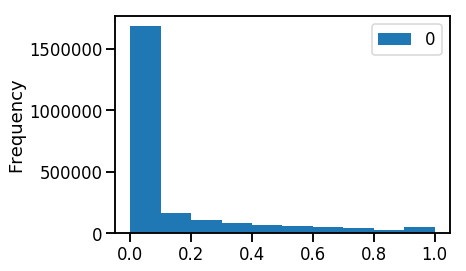

In [29]:
pd.DataFrame(y_test).plot.hist()

In [30]:
print('Test duplicates with >0.9 confidence:', len(df_submission[df_submission.is_duplicate > 0.9]))
print('Test mean prediction:', np.mean(y_test))
print('Calibrated mean prediction:', df_submission['is_duplicate'].mean())

Test duplicates with >0.9 confidence: 41361
Test mean prediction: 0.1289686076366504
Calibrated mean prediction: 0.07675923901380191


In [31]:
if not os.path.exists(project.submissions_dir):
    os.makedirs(project.submissions_dir)

In [32]:
df_submission.to_csv(
    project.submissions_dir + f'{submission_id}-submission-draft-cv-{final_cv_score:.6f}.csv',
    header=True,
    float_format='%.8f',
    index=None,
)